In [1]:
import pandas as pd
import numpy as np
import json
from pandas import json_normalize
# from google.colab import files
import pyarrow.parquet as pq
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

import warnings
warnings.filterwarnings('ignore')

In [2]:
df_1Q22 = pd.read_parquet('data/df_1Q22.parquet')
df_2Q22 = pd.read_parquet('data/df_2Q22.parquet')
df_3Q22 = pd.read_parquet('data/df_3Q22.parquet')
df_4Q22 = pd.read_parquet('data/df_4Q22.parquet')
df_1Q23 = pd.read_parquet('data/df_1Q23.parquet')
df_2Q23 = pd.read_parquet('data/df_2Q23.parquet')
df_2Q23.head()

,ent,frequency,Avg_spend,Avg_Discount,mtbp,online_ratio
0,8CCCCCC4R1F,1,367500.0,0.675676,1.0,1.00
1,BC14413K,1,1118000.0,8.210181,1.0,0.00
2,BCCCCRE3C4F,1,335000.0,0.000000,1.0,1.00
3,BCCCCREW3WY,4,469750.0,23.495370,20.0,0.75
4,BCE4JERY,4,1687250.0,0.000000,15.0,0.00


# 2Q23

### Data Transformation
Transform Data to make data more Gaussian-like.
- The most common statistical assumption data scientists make is that their data is from a gaussian distibution, and furthermore many of the most common machine learning models are built upon that assumption. Because many ML tools require gaussian-like data the first check before implementing a model is to determine of the data is Gaussian-like.

Power transforms
- Power transforms are a family of parametric, monotonic transformations that are applied to make data more Gaussian-like. This is useful for modeling issues related to heteroscedasticity (non-constant variance), or other situations where normality is desired.
- Currently, PowerTransformer supports the Box-Cox transform and the Yeo-Johnson transform. The optimal parameter for stabilizing variance and minimizing skewness is estimated through maximum likelihood.
- Box-Cox requires input data to be strictly positive, while Yeo-Johnson supports both positive or negative data.
- By default, zero-mean, unit-variance normalization is applied to the transformed data.

*** Normality - Before transform ***
===== frequency =====
Statistics=0.563, p=0.000
Probably not Gaussian
===== Avg_spend =====
Statistics=0.895, p=0.000
Probably not Gaussian
===== Avg_Discount =====
Statistics=0.438, p=0.000
Probably not Gaussian
===== mtbp =====
Statistics=0.738, p=0.000
Probably not Gaussian
===== online_ratio =====
Statistics=0.765, p=0.000
Probably not Gaussian


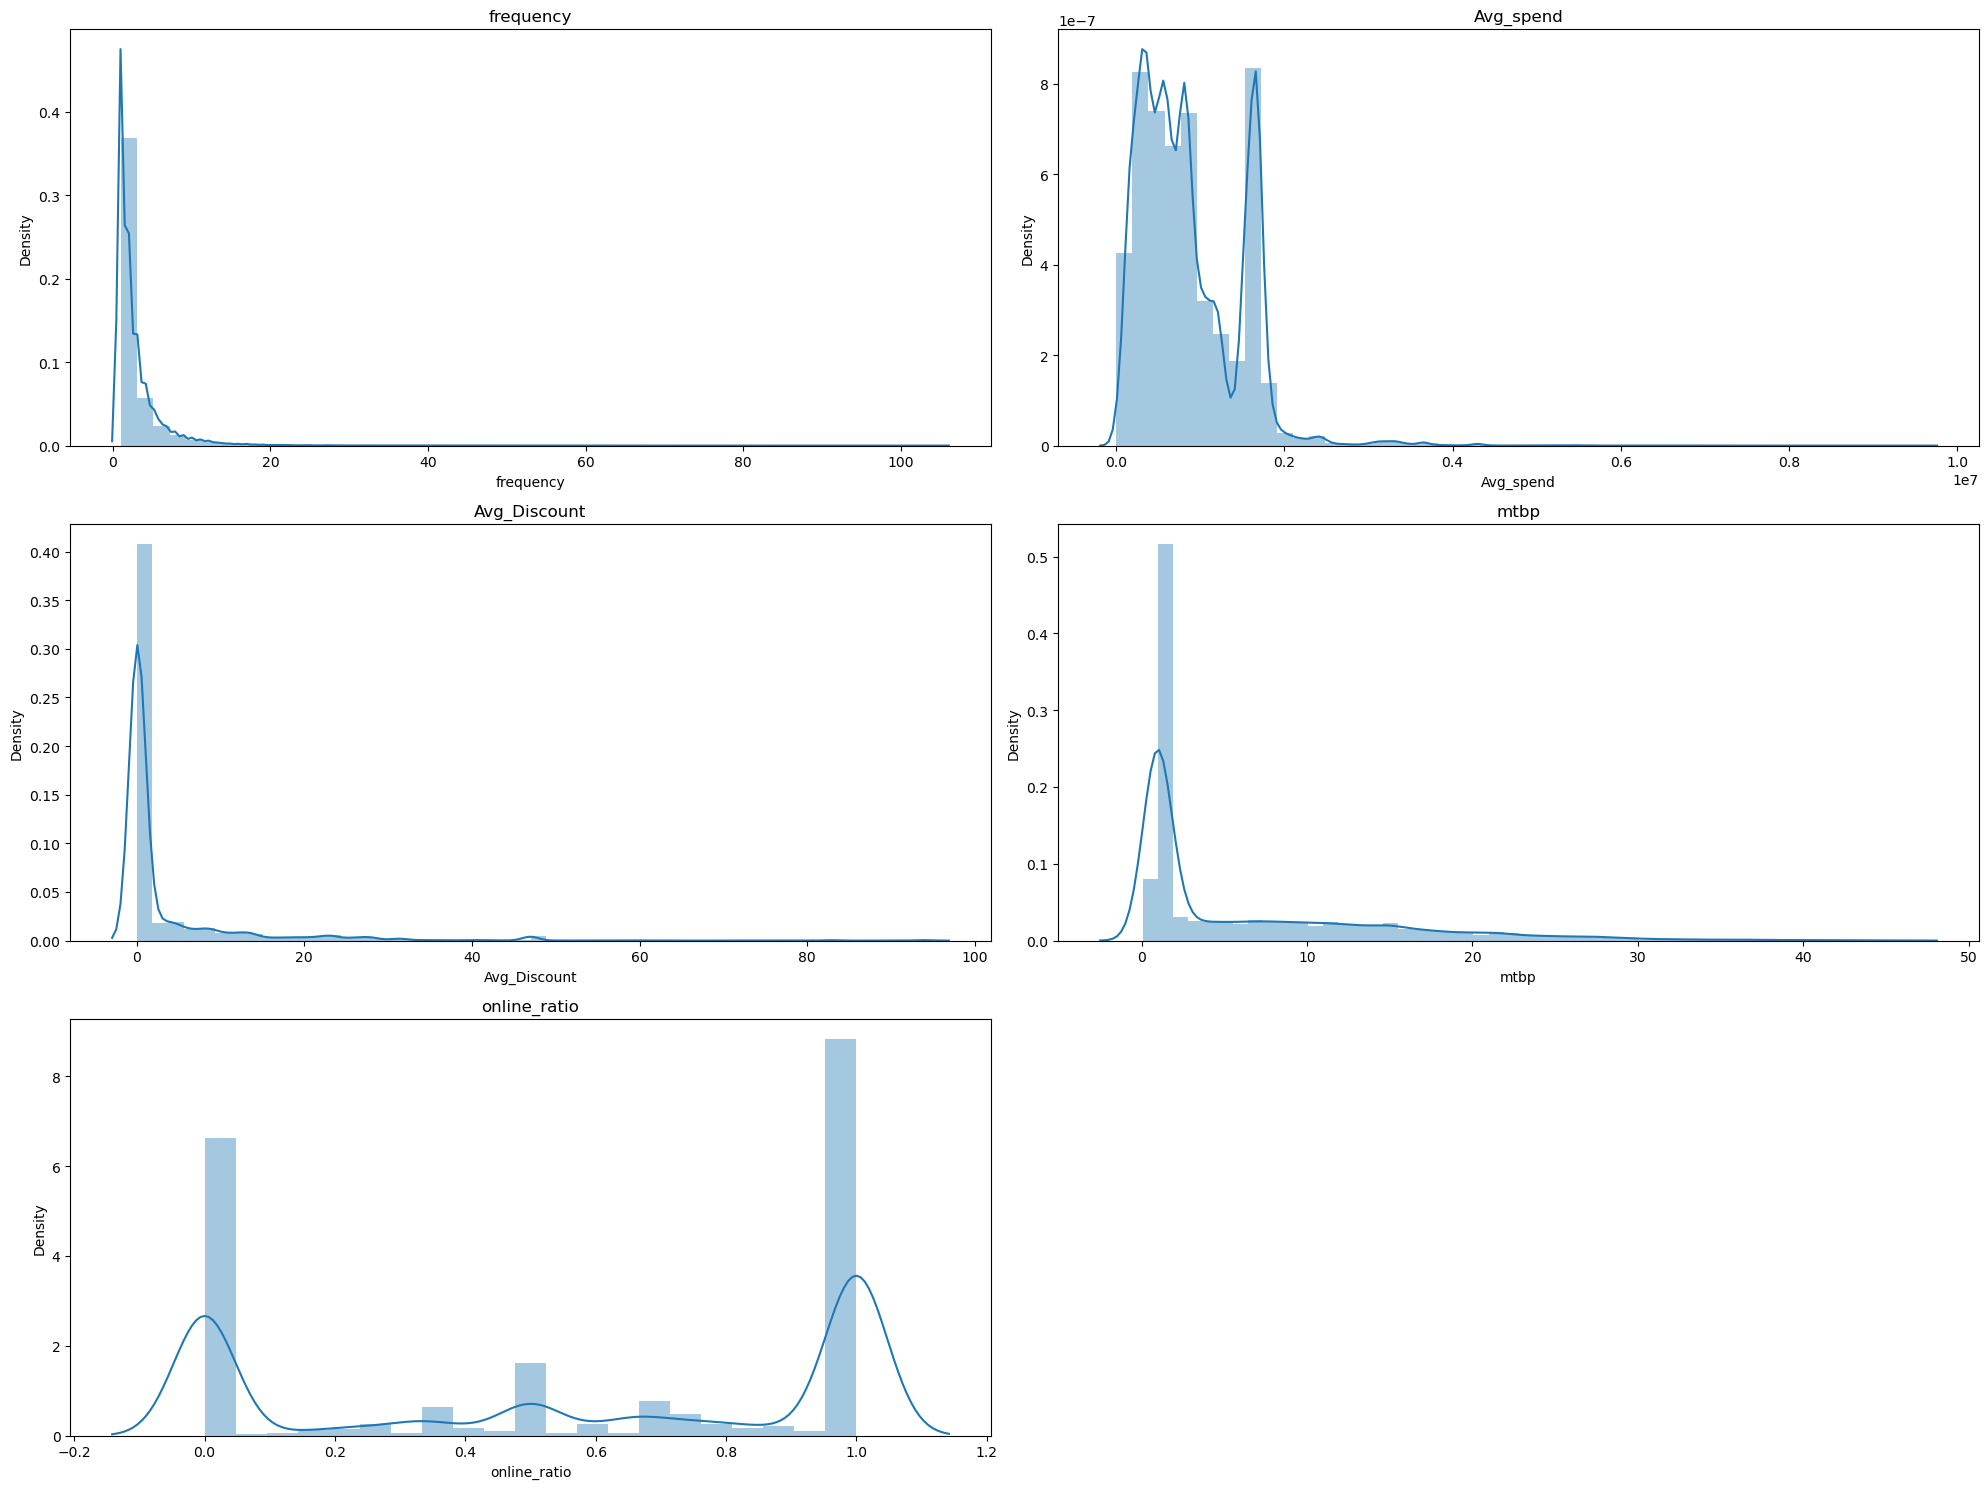

In [3]:
def normality_test(df):
    from scipy.stats import shapiro
    for col in df.columns:
        stat, p = shapiro(df[col]) # shapiro test
        if p <= 0.05:
            print(f'===== {col} =====')
            print('Statistics=%.3f, p=%.3f' % (stat, p))
            print('Probably not Gaussian')

def distribution_plot(df):
    # 2 columns per row
    num_cols = len(df.columns)
    num_rows = (num_cols + 1) // 2  # Calculate the number of rows based on the number of columns

    fig, ax = plt.subplots(num_rows, 2, figsize=(20, 5*num_rows))
    for i, col in enumerate(df.columns):
        sns.distplot(df[col], ax=ax[i//2, i%2])
        ax[i//2, i%2].set_title(col)

    # Remove any unused subplots
    if num_cols < num_rows * 2:
        for j in range(num_cols % 2, 2):
            fig.delaxes(ax[num_rows-1, j])
    plt.tight_layout()
    plt.show()

df_2Q23.set_index('ent', inplace=True)

print('*** Normality - Before transform ***')
normality_test(df_2Q23)
distribution_plot(df_2Q23)

*** Normality - After transform ***


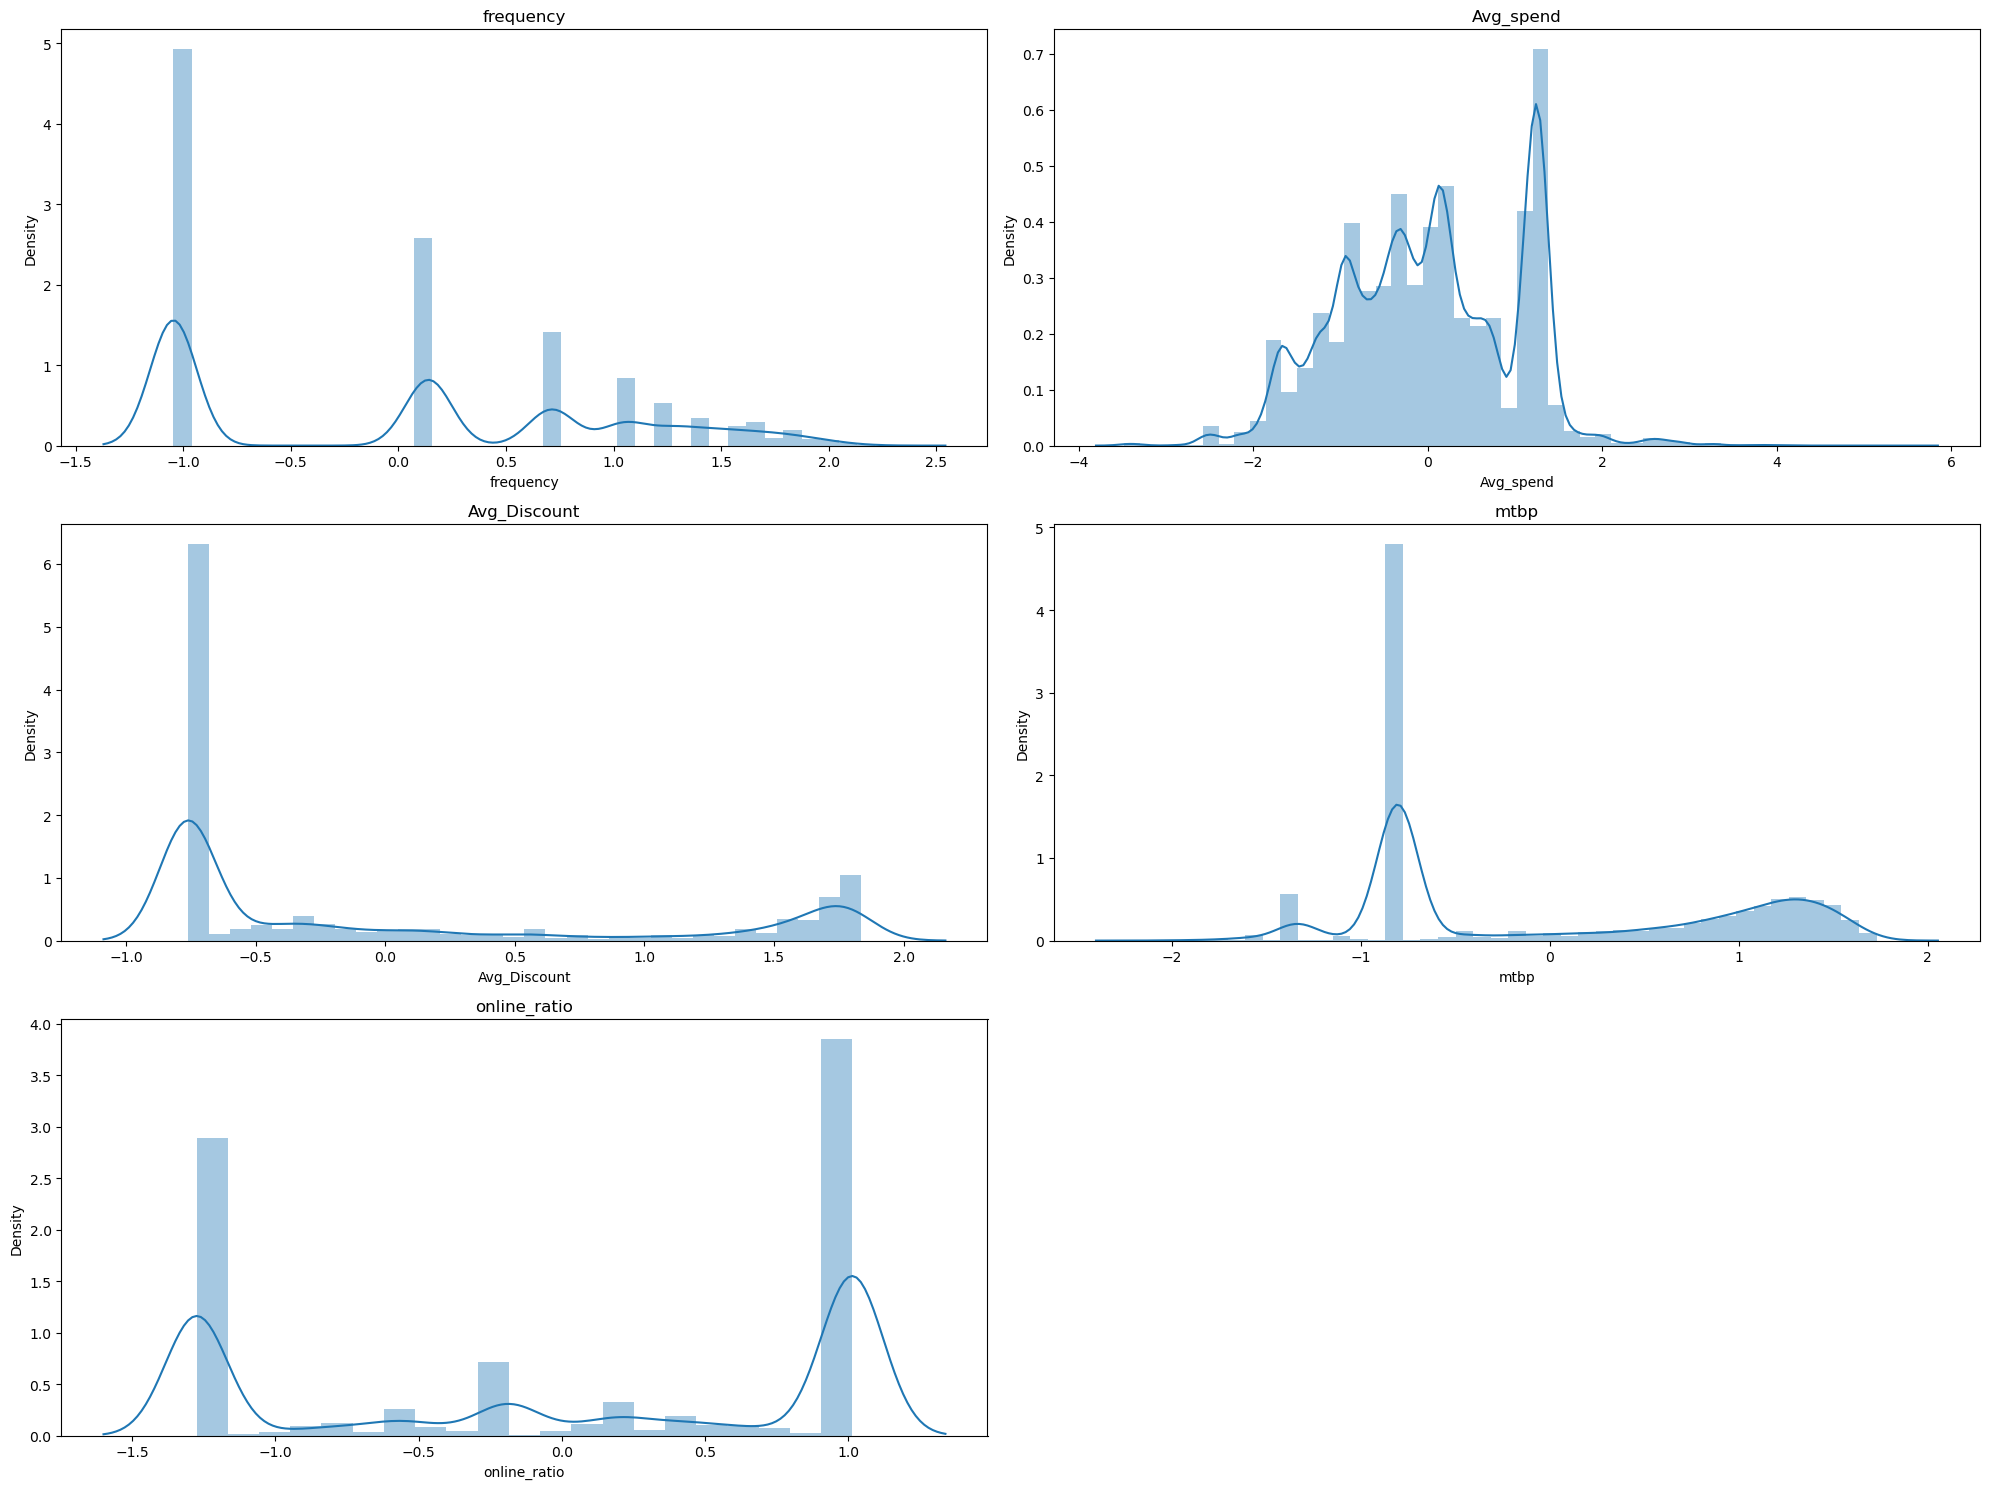

In [4]:
# power transform
from sklearn.preprocessing import PowerTransformer
pt = PowerTransformer() #default=’yeo-johnson’

df_2Q23_transform = pd.DataFrame(pt.fit_transform(df_2Q23))
df_2Q23_transform.columns = df_2Q23.columns

print('*** Normality - After transform ***')
# normality_test(seg_transform)
distribution_plot(df_2Q23_transform)


# Principle Component Analysis (PCA)

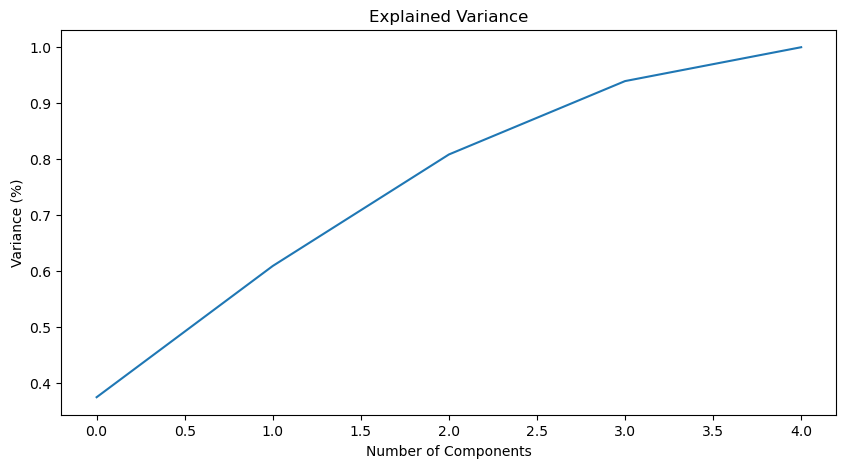

In [5]:
from sklearn.decomposition import PCA

pca = PCA()
pca.fit(df_2Q23_transform)
pca.explained_variance_ratio_

# Plotting the Cumulative Summation of the Explained Variance
plt.figure(figsize=(10,5))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Variance (%)') #for each component
plt.title('Explained Variance')
plt.show()

rule of thumb is to keep at least 70 to 80 percent of the explained variance.
So Let’s keep the first 2 components for our further analysis.

In [6]:
pca = PCA(n_components=2)
pca.fit(df_2Q23_transform)
print("explained_variance_ratio_:", pca.explained_variance_ratio_)

df_2Q23_PCA = pd.DataFrame(pca.transform(df_2Q23_transform), columns=(["PC1","PC2"]))
df_2Q23_PCA.describe().T

explained_variance_ratio_: [0.37432041 0.23465885]


,count,mean,std,min,25%,50%,75%,max
PC1,66992.0,-1.764902e-16,1.368075,-2.175500,-1.343706,-0.231004,1.249423,2.623823
PC2,66992.0,-1.697021e-17,1.083195,-2.874549,-0.781243,-0.019642,0.741107,4.977667


,frequency,Avg_spend,Avg_Discount,mtbp,online_ratio
PC-1,0.647418,-0.125306,0.397141,0.636322,0.050219
PC-2,-0.135936,0.798201,0.459494,0.037369,-0.363132


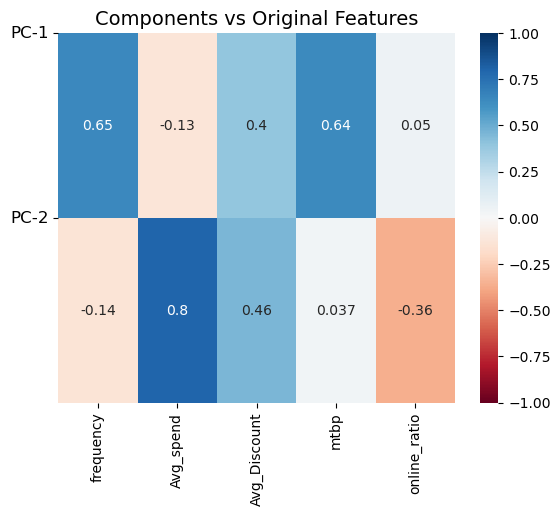

In [7]:
df_pca_comp = pd.DataFrame(pca.components_,columns=df_2Q23_transform.columns,index = ['PC-1','PC-2'])
display(df_pca_comp)

# heatmap
sns.heatmap(df_pca_comp,
            vmin = -1,
            vmax = 1,
            cmap = 'RdBu',
            annot = True)
plt.yticks([0,1],['PC-1','PC-2'], rotation = 360, fontsize = 12)
plt.title('Components vs Original Features',fontsize = 14)
plt.show()

# K-Means Clustering

In [8]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from yellowbrick.cluster import KElbowVisualizer

Elbow Method to determine the number of clusters to be formed:


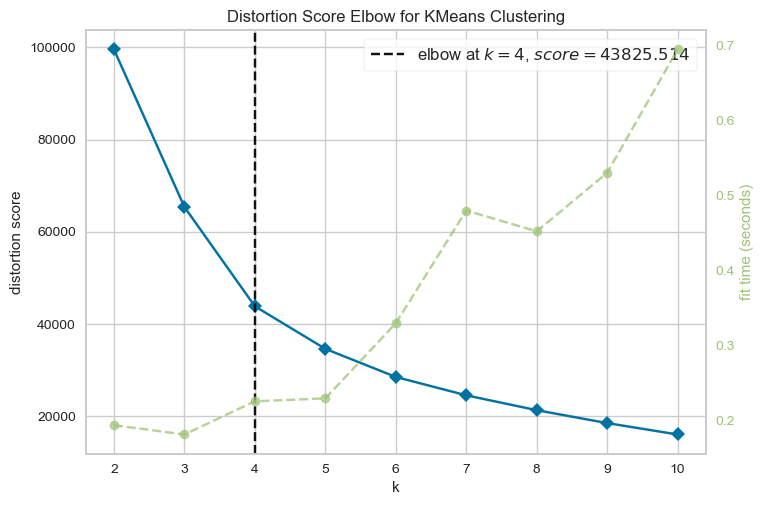

In [9]:
# choose k by elbow method
# Quick examination of elbow method to find numbers of clusters to make.
print('Elbow Method to determine the number of clusters to be formed:')
Elbow_M = KElbowVisualizer(KMeans(random_state=42), k=10, scoere='calinski_harabasz')
Elbow_M.fit(df_2Q23_PCA)
Elbow_M.show();

In [10]:
# Initialize and fit the K-means model
kmeans = KMeans(n_clusters=4, random_state=42)

# Fit model and predict clusters
cluster = kmeans.fit_predict(df_2Q23_PCA)

# create a new column in the scaled dataframe with the cluster labels
df_2Q23_PCA["Clusters"] = cluster
df_2Q23_PCA


,PC1,PC2,Clusters
0,-0.838405,-0.711106,2
1,-0.659414,1.833861,1
2,-1.321950,-1.363518,2
3,2.396747,0.134065,0
4,0.975153,1.054672,0
...,...,...,...
66987,-1.712954,1.226169,1
66988,2.261141,0.915815,0
66989,2.244970,-0.326750,0
66990,2.163439,0.438202,0


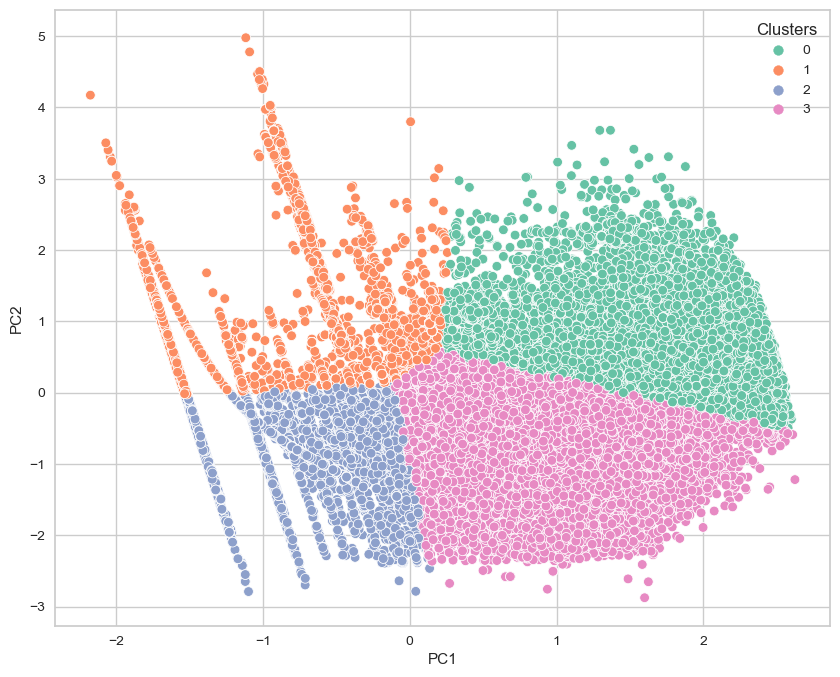

In [37]:
plt.figure(figsize=(10,8))
sns.scatterplot(x="PC1", y="PC2", hue="Clusters", data=df_2Q23_PCA, palette="Set2", legend='full')


plt.show()

,frequency,Avg_spend,Avg_Discount,mtbp,online_ratio
Segment,,,,,
Loyal High-Spenders,4.92,1011388.86,9.98,13.41,0.49
Occasional Big-Spenders,1.14,1489063.92,3.57,1.02,0.43
Online Value Shoppers,1.45,415335.76,1.15,0.95,0.69
Frequent Online Shoppers,4.47,529613.00,0.39,11.41,0.65


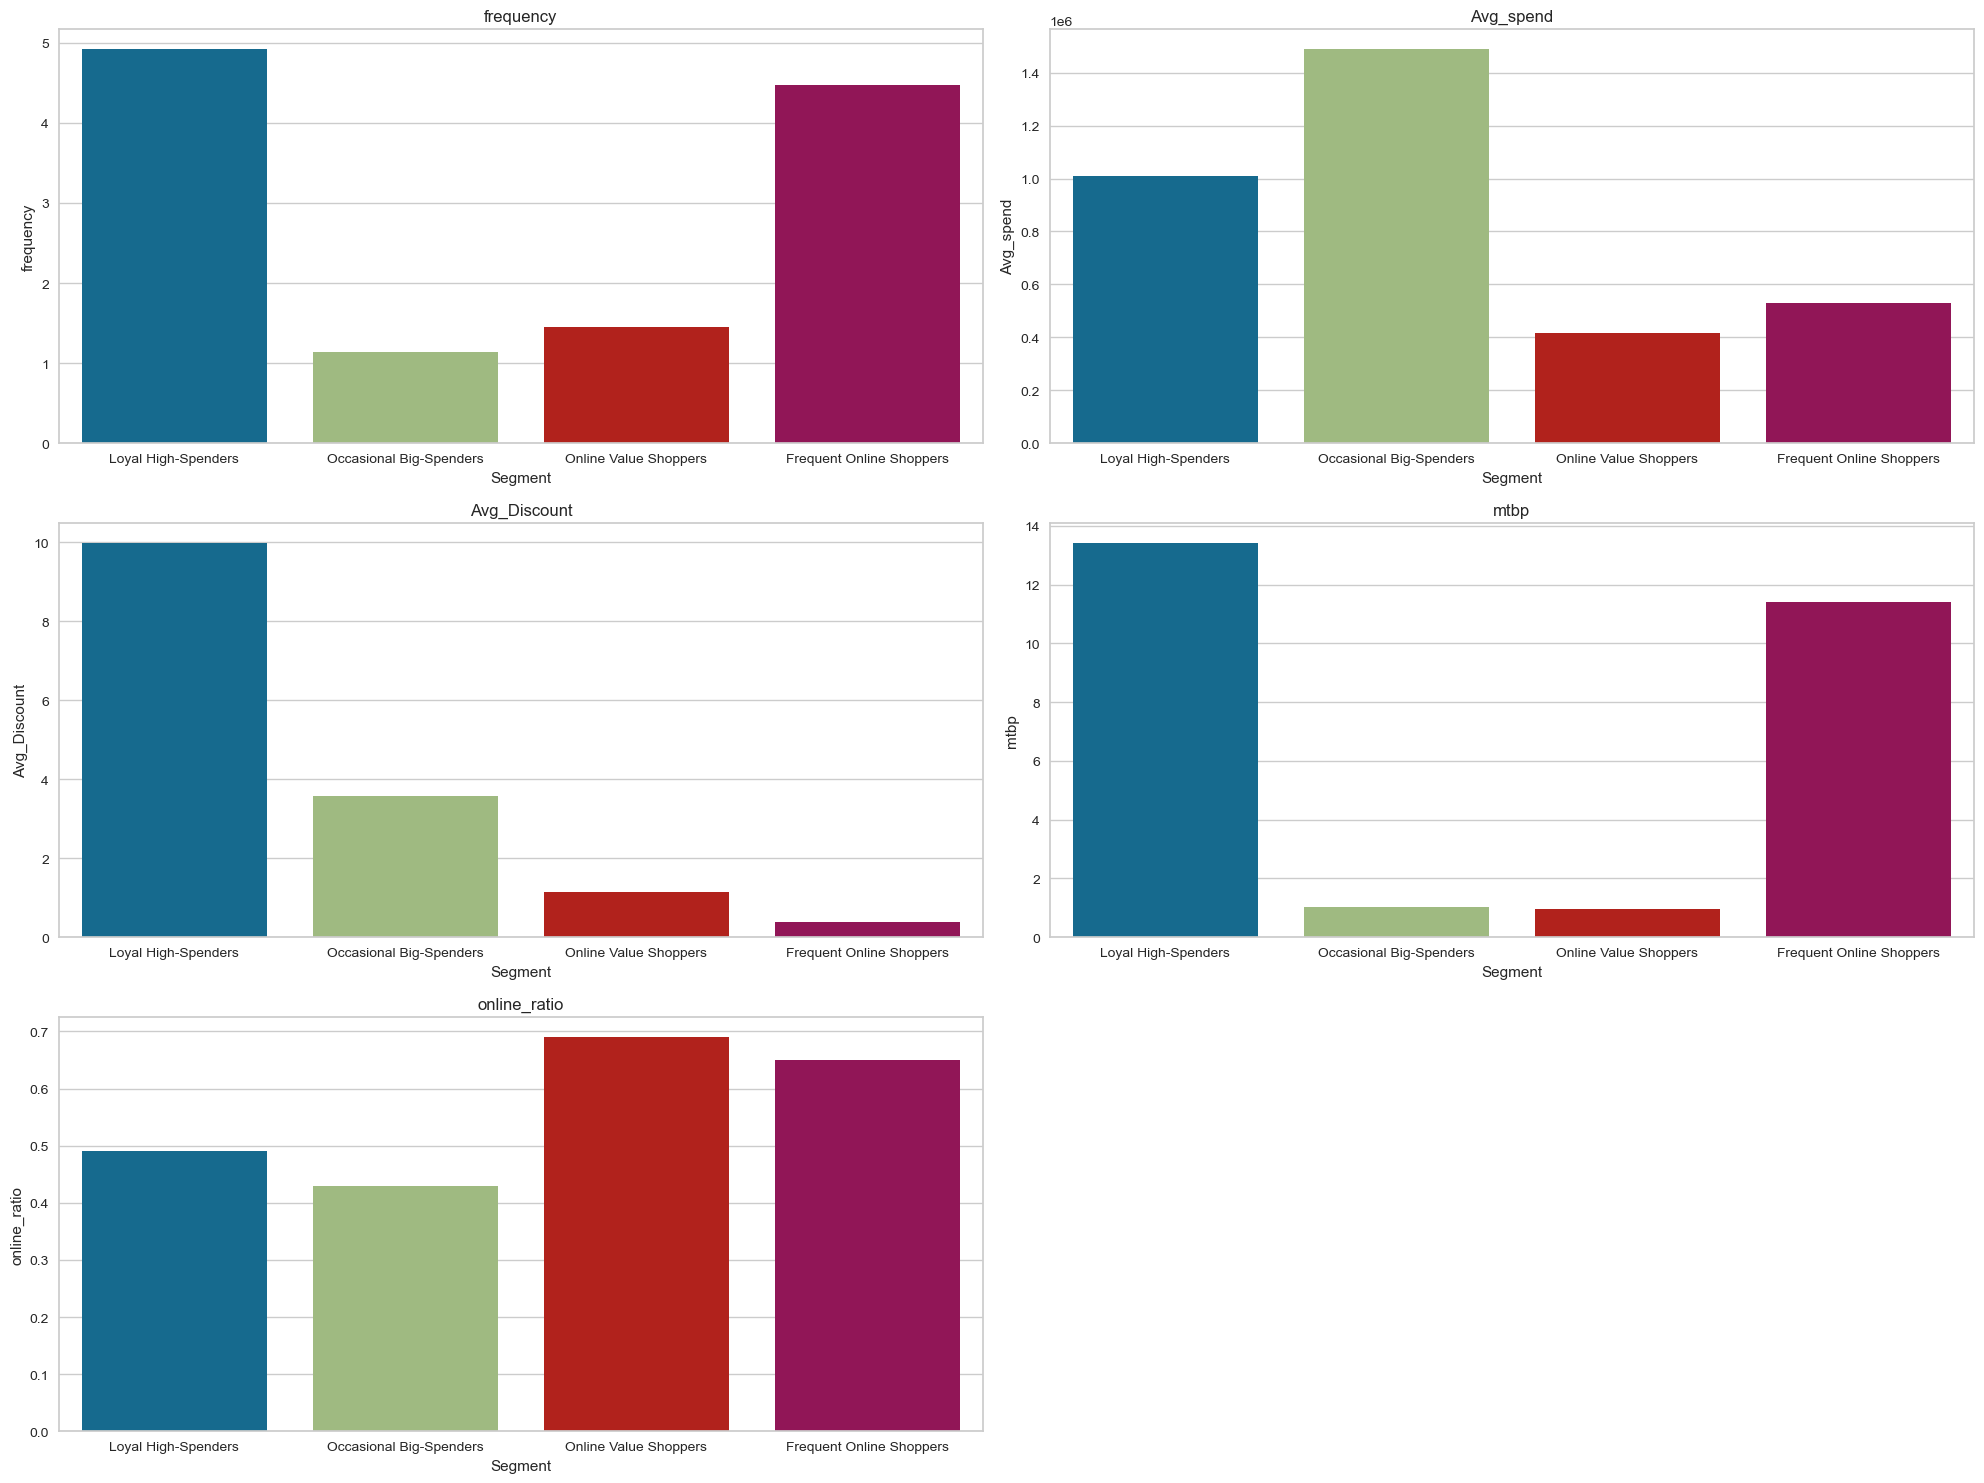

In [29]:
def bar_plot(df):
    # 2 columns
    num_cols = len(df.columns)
    num_rows = (num_cols + 1) // 2  # Calculate the number of rows based on the number of columns

    fig, ax = plt.subplots(num_rows, 2, figsize=(20, 5*num_rows))
    for i, col in enumerate(df.columns):
        sns.barplot(x=df.index, y=df[col], ax=ax[i//2, i%2])
        ax[i//2, i%2].set_title(col)

    # Remove any unused subplots
    if num_cols < num_rows * 2:
        for j in range(num_cols % 2, 2):
            fig.delaxes(ax[num_rows-1, j])
    plt.tight_layout()
    plt.show()

df_2Q23_seg = df_2Q23.copy()
df_2Q23_seg["Clusters"] = df_2Q23_PCA["Clusters"].values

df_seg_analysis = df_2Q23_seg.groupby(["Clusters"]).mean().round(2)
# map cluster to segment name
seg_map = {0: 'Loyal High-Spenders', 1: 'Occasional Big-Spenders',
              2: 'Online Value Shoppers', 3: 'Frequent Online Shoppers'}

df_seg_analysis['Segment'] = df_seg_analysis.index.map(seg_map)
df_seg_analysis.set_index('Segment', inplace=True)
df_seg_analysis.to_csv('data/df_seg_analysis.csv')
display(df_seg_analysis)
bar_plot(df_seg_analysis)

In [27]:
df_2Q23_seg
df_2Q23_seg.head()

,frequency,Avg_spend,Avg_Discount,mtbp,online_ratio,Clusters,Segment
ent,,,,,,,
8CCCCCC4R1F,1,367500.0,0.675676,1.0,1.00,2,Online Value Shoppers
BC14413K,1,1118000.0,8.210181,1.0,0.00,1,Occasional Big-Spenders
BCCCCRE3C4F,1,335000.0,0.000000,1.0,1.00,2,Online Value Shoppers
BCCCCREW3WY,4,469750.0,23.495370,20.0,0.75,0,Loyal High-Spenders
BCE4JERY,4,1687250.0,0.000000,15.0,0.00,0,Loyal High-Spenders


### Other quarter

In [14]:
def cus_segment(df):
    # pt = PowerTransformer() #default=’yeo-johnson’
    # pca = PCA(n_components=2)
    # kmeans = KMeans(n_clusters=4, random_state=42)

    df.set_index('ent', inplace=True)
    
    # power transform
    df_transform = pd.DataFrame(pt.transform(df))
    df_transform.columns = df.columns

    # PCA
    df_PCA = pd.DataFrame(pca.transform(df_transform), columns=(["PC1","PC2"]))

    # kmeans
    cluster = kmeans.predict(df_PCA)
    df_PCA["Clusters"] = cluster

    # analysis
    df_seg = df.copy()
    df_seg["Clusters"] = df_PCA["Clusters"].values

    return df_seg

In [15]:
df_1Q22_seg = cus_segment(df_1Q22)
df_2Q22_seg = cus_segment(df_2Q22)
df_3Q22_seg = cus_segment(df_3Q22)
df_4Q22_seg = cus_segment(df_4Q22)
df_1Q23_seg = cus_segment(df_1Q23)
df_1Q23_seg.head()

,frequency,Avg_spend,Avg_Discount,mtbp,online_ratio,Clusters
ent,,,,,,
8CCCCCC4R1F,1,1502500.0,0.166113,1.0,1.0,1
BCCCCRE3C4F,2,621250.0,0.000000,0.5,0.5,2
BCCCCRE3Q40,1,1080500.0,0.230840,1.0,1.0,1
BCCCCREW3WY,5,1022520.0,0.000000,3.4,0.4,3
BCCCCREWJZ5,1,521000.0,0.000000,1.0,1.0,2


In [21]:
# map cluster to segment name
seg_map = {0: 'Loyal High-Spenders', 1: 'Occasional Big-Spenders',
              2: 'Online Value Shoppers', 3: 'Frequent Online Shoppers'}

df_1Q22_seg['Segment'] = df_1Q22_seg['Clusters'].map(seg_map)
df_2Q22_seg['Segment'] = df_2Q22_seg['Clusters'].map(seg_map)
df_3Q22_seg['Segment'] = df_3Q22_seg['Clusters'].map(seg_map)
df_4Q22_seg['Segment'] = df_4Q22_seg['Clusters'].map(seg_map)
df_1Q23_seg['Segment'] = df_1Q23_seg['Clusters'].map(seg_map)
df_2Q23_seg['Segment'] = df_2Q23_seg['Clusters'].map(seg_map)
df_2Q23_seg.head()

,frequency,Avg_spend,Avg_Discount,mtbp,online_ratio,Clusters,Segment
ent,,,,,,,
8CCCCCC4R1F,1,367500.0,0.675676,1.0,1.00,2,Online Value Shoppers
BC14413K,1,1118000.0,8.210181,1.0,0.00,1,Occasional Big-Spenders
BCCCCRE3C4F,1,335000.0,0.000000,1.0,1.00,2,Online Value Shoppers
BCCCCREW3WY,4,469750.0,23.495370,20.0,0.75,0,Loyal High-Spenders
BCE4JERY,4,1687250.0,0.000000,15.0,0.00,0,Loyal High-Spenders


In [23]:
# to parquet
df_1Q22_seg.to_parquet('data/df_1Q22_seg.parquet')
df_2Q22_seg.to_parquet('data/df_2Q22_seg.parquet')
df_3Q22_seg.to_parquet('data/df_3Q22_seg.parquet')
df_4Q22_seg.to_parquet('data/df_4Q22_seg.parquet')
df_1Q23_seg.to_parquet('data/df_1Q23_seg.parquet')
df_2Q23_seg.to_parquet('data/df_2Q23_seg.parquet')

# Feature Importance

In [22]:
df_2Q23_seg

,frequency,Avg_spend,Avg_Discount,mtbp,online_ratio,Clusters,Segment
ent,,,,,,,
8CCCCCC4R1F,1,367500.0,0.675676,1.00,1.0000,2,Online Value Shoppers
BC14413K,1,1118000.0,8.210181,1.00,0.0000,1,Occasional Big-Spenders
BCCCCRE3C4F,1,335000.0,0.000000,1.00,1.0000,2,Online Value Shoppers
BCCCCREW3WY,4,469750.0,23.495370,20.00,0.7500,0,Loyal High-Spenders
BCE4JERY,4,1687250.0,0.000000,15.00,0.0000,0,Loyal High-Spenders
...,...,...,...,...,...,...,...
TZZZEQ4Y,1,1647000.0,0.000000,1.00,0.0000,1,Occasional Big-Spenders
TZZZJ3WP,10,1034550.0,3.348214,8.70,0.5000,0,Loyal High-Spenders
TZZZREZF,8,216375.0,11.747685,4.75,0.3750,0,Loyal High-Spenders


Clusters
1           0.282406
3           0.265315
2           0.247887
0           0.204392
Name: proportion, dtype: float64
Clusters
1           0.282409
3           0.265318
2           0.247854
0           0.204418
Name: proportion, dtype: float64
Accuracy: 0.9944771997910292


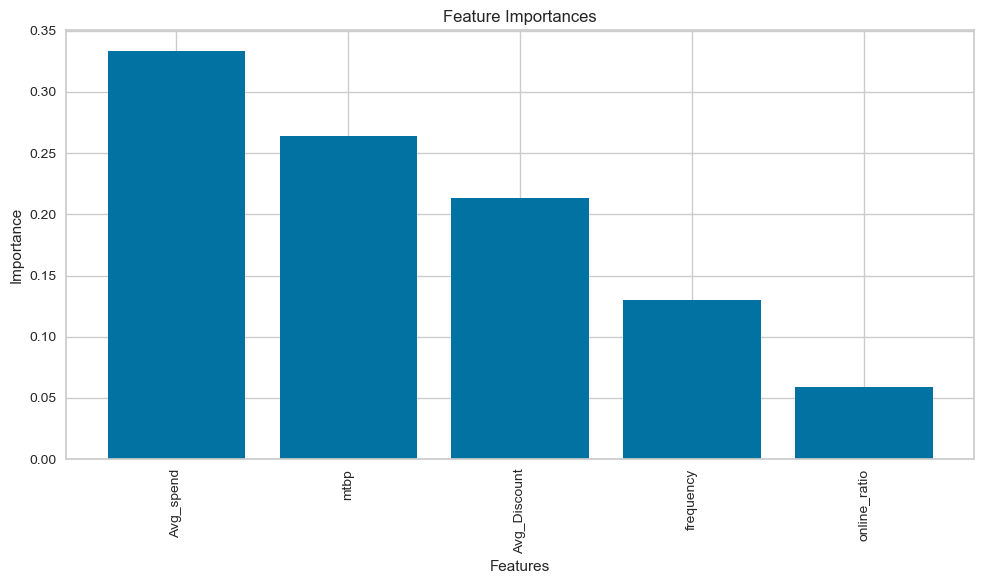

In [25]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

df_fea = df_2Q23_seg.copy()
df_fea.drop(columns=["Clusters", "Segment"], inplace=True)
# power transform
df_fea_transform = pd.DataFrame(pt.transform(df_fea))
df_fea_transform.columns = df_fea.columns

# feature importance
X_fea_imp = df_fea_transform
y_fea_imp = pd.DataFrame(df_2Q23_seg["Clusters"])

# split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_fea_imp, y_fea_imp, test_size=0.2, random_state=42, stratify = y_fea_imp)
print(y_train.value_counts(normalize=True))
print(y_test.value_counts(normalize=True))

### Random Forest classifier ###
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
# Fit the classifier to the training data
rf_classifier.fit(X_train, y_train)
# Make predictions on the test set
y_pred = rf_classifier.predict(X_test)
# Evaluate the accuracy of the classifier
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

### Get feature importances ###
feature_importances = rf_classifier.feature_importances_
# Create a DataFrame of feature importances
importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

#### Plot feature importances ####
plt.figure(figsize=(10, 6))
plt.bar(importance_df['Feature'], importance_df['Importance'])
plt.xticks(rotation=90)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature Importances')
plt.tight_layout()
plt.show()